In [1]:
import pandas as pd
import keras
import numpy as np
import sys
sys.path.append('../')
from src.models import combined_cnn
from src.generator import generator_two_inputs
from src.loss import smoothed_binary_crossentropy
sys.path.append('/notebook')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [2]:
# import dataframe with filenames and labels
sample = pd.read_csv('../labels/training_labels_updated.csv')
sample['temp_label'] = sample['final_label'].apply(lambda x: np.round(x))
sample['temp_label'] = sample['temp_label'].astype('int').astype('str')
sample['final_label'] =  sample['final_label'].astype('str')

train_data, test_data = train_test_split(sample, test_size = 0.25, random_state = 100)

In [3]:
# # import dataframe with filenames and labels
# labels = pd.read_csv('../labels/training_labels.csv')
# labels['full_label'] = 'aerial_' + labels['AERIAL_Driveway'].astype(int).astype(str) + \
#                        '_gsv_' + labels['GSV_Driveway'].astype(int).astype(str)

# # use train test split
# train_data, test_data = train_test_split(labels, test_size = 0.25, random_state = 100)

In [4]:
# train_data = train_data[train_data.final_label != '0.5']

In [5]:
# train_data.groupby('temp_label').aggregate({'ADDR_NUM':len})

In [6]:
# train_data = ((train_data[train_data.temp_label == '1']).sample(36)).append(train_data[train_data.temp_label == '0'])

In [7]:
# train_data.shape

In [8]:
# train_data.head(20)

^ clearly there's an imbalanced class problem

In [10]:
# input parameters
batch_size = 16
epochs = 5

In [11]:
model = combined_cnn(gsv_image_dim = (128,128, 3), sat_image_dim = ((128,128, 4)), 
                     n_classes = 1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gsv_image_input (InputLayer)    (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
aerial_image_input (InputLayer) (None, 128, 128, 4)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 128 3584        gsv_image_input[0][0]            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 126, 126, 128 4736        aerial_image_input[0][0]         
__________________________________________________________________________________________________
max_poolin

In [12]:
#implement class weights as an easy first attempt to handle imbalanced class problem
# class_weight = {1.0: 1,
#                 0.0: 2}

In [13]:
history = model.fit_generator(
                # train 
                generator_two_inputs(train_data, aerial_dir = '../data/training/aerial_images/', 
                gsv_dir ='data/training/street_view_images/', batch_size = batch_size, 
                gsv_image_dim = (128,128, 3), aer_image_dim = (128,128, 4), y_column = 'temp_label'),
                
                validation_data=generator_two_inputs(test_data, aerial_dir = '../data/training/aerial_images/', 
                gsv_dir ='data/training/street_view_images/', batch_size = batch_size, 
                gsv_image_dim = (128,128, 3), aer_image_dim = (128,128, 4), y_column = 'temp_label'),
                
                validation_steps = 5,
                steps_per_epoch=np.ceil(sample.shape[0]//batch_size), 
                epochs=epochs,
#                 class_weight = class_weight,
                verbose=1)

Epoch 1/5
Found 215 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.
16/17 [===========================>..] - ETA: 3s - loss: 1.7817 - acc: 0.6551 - sensitivity: 0.8135 - specificity: 0.1429Found 72 validated image filenames belonging to 2 classes.
Found 72 validated image filenames belonging to 2 classes.
17/17 [==============================] - 78s 5s/step - loss: 1.6919 - acc: 0.6677 - sensitivity: 0.8202 - specificity: 0.1347 - val_loss: 1.0473 - val_acc: 0.6806 - val_sensitivity: 0.8152 - val_specificity: 0.0741
Epoch 2/5
17/17 [==============================] - 59s 3s/step - loss: 1.3239 - acc: 0.6264 - sensitivity: 0.7470 - specificity: 0.3481 - val_loss: 1.5215 - val_acc: 0.8056 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 3/5
17/17 [==============================] - 52s 3s/step - loss: 0.9251 - acc: 0.7251 - sensitivity: 0.8781 - specificity: 0.1100 - val_loss: 0.8986 - val_acc: 0.7222 - val_sensitiv

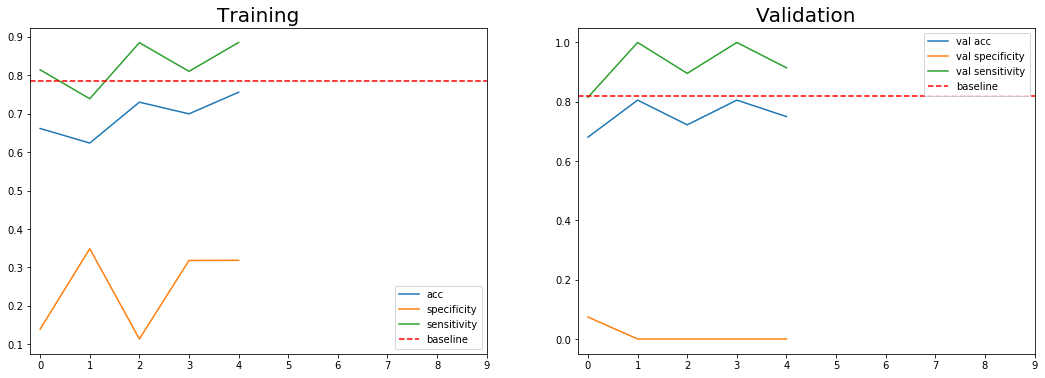

In [14]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1); plt.title('Training', fontsize = 20)
plt.plot(history.history['acc'], label = 'acc')
plt.plot(history.history['specificity'], label = 'specificity')
plt.plot(history.history['sensitivity'], label = 'sensitivity')
plt.axhline((train_data.temp_label).astype('float32').sum()/train_data.shape[0], ls = '--', c = 'r', label = 'baseline')
plt.xticks(np.arange(0,10))
plt.legend()
plt.subplot(1,2,2); plt.title('Validation', fontsize = 20)
plt.plot(history.history['val_acc'], label = 'val acc')
plt.plot(history.history['val_specificity'], label = 'val specificity')
plt.plot(history.history['val_sensitivity'], label = 'val sensitivity')
plt.axhline((test_data.temp_label).astype('float32').sum()/test_data.shape[0], ls = '--', c = 'r', label = 'baseline')
plt.xticks(np.arange(0,10))
plt.legend();

In [13]:
# plt.plot(history.history['specificity'])

In [15]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_sensitivity', 'val_specificity', 'loss', 'acc', 'sensitivity', 'specificity'])

In [16]:
addresses_gsv_filename = ['1_ESSEX_ST.jpg', '8_GILMAN_ST.jpg', '9_MELVILLE_RD.jpg','10_CENTRAL_ST.jpg',
                         '14_MANSFIELD_ST.jpg']
pred_sample = sample[sample.gsv_filename.isin(addresses_gsv_filename)]
pred_sample

,ADDR_NUM,FULL_STR,MBL,ADDRESS_FOR_STREET_VIEW,AERIAL_Driveway,GSV_Driveway,final_label,aerial_filename,gsv_filename,temp_label
0,1,ESSEX ST,50-B-12,"1 ESSEX ST, SOMERVILLE, MA",2,1,0.9,1_ESSEX_ST_aerial.png,1_ESSEX_ST.jpg,1
25,8,GILMAN ST,92-J-10,"8 GILMAN ST, SOMERVILLE, MA",1,2,0.9,8_GILMAN_ST_aerial.png,8_GILMAN_ST.jpg,1
37,9,MELVILLE RD,55-C-13,"9 MELVILLE RD, SOMERVILLE, MA",1,1,1.0,9_MELVILLE_RD_aerial.png,9_MELVILLE_RD.jpg,1
51,10,CENTRAL ST,44-F-8,"10 CENTRAL ST, SOMERVILLE, MA",0,0,0.0,10_CENTRAL_ST_aerial.png,10_CENTRAL_ST.jpg,0
78,14,MANSFIELD ST,81-B-16,"14 MANSFIELD ST, SOMERVILLE, MA",2,2,0.5,14_MANSFIELD_ST_aerial.png,14_MANSFIELD_ST.jpg,0


In [17]:
model.predict_generator(generator_two_inputs(pred_sample, aerial_dir = '../data/training/aerial_images/', 
                gsv_dir ='data/training/street_view_images/', batch_size = batch_size, 
                 gsv_image_dim = (128,128, 3), aer_image_dim = (128,128, 4), y_column = 'temp_label'),
                      steps = 1 )

Found 5 validated image filenames belonging to 2 classes.
Found 5 validated image filenames belonging to 2 classes.


array([[0.81862664],
       [0.9158333 ],
       [0.7533158 ],
       [0.77781636],
       [0.9597675 ]], dtype=float32)

In [16]:
model.predict_generator(generator_two_inputs(pred_sample, aerial_dir = '../data/training/aerial_images/', 
                gsv_dir ='data/training/street_view_images/', batch_size = batch_size, 
                 gsv_image_dim = (128,128, 3), aer_image_dim = (128,128, 4), y_column = 'temp_label'),
                      steps = 1 )

Found 5 validated image filenames belonging to 2 classes.
Found 5 validated image filenames belonging to 2 classes.


array([[0.91346025],
       [0.69096094],
       [0.4599434 ],
       [0.9577801 ],
       [0.49642584]], dtype=float32)

In [15]:
# save basic model
import pickle
with open('../models/basicmodelhistory.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [17]:
model.save('../models/basicmodel.h5')

In [18]:
model.save_weights('../models/basicmodel_weights.h5')